In [7]:
import pandas as pd
import numpy as np
import utils
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
def get_indices_entire_sequence(
    data: pd.DataFrame, # dataset ex. training
    window_size: int, # input squence + target (lag + horizon)
    step_size: int # step to take in data by moving window
    ) -> list:

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [4]:
def get_xgboost_x_y(
    indices: list, #subsequence tuples (start, end)
    data: np.array,
    target_sequence_length, # horizon
    input_seq_len: int # length of input
    ):              #-> Tuple[np.array, np.array]

    # Loop over list of training indices
    for i, idx in enumerate(indices):

        # Slice data into instance of length input length + target length
        data_instance = data[idx[0]:idx[1]]

        x = data_instance[0:input_seq_len]

        assert len(x) == input_seq_len

        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0) # shape (datapoints, horizon)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0) # shape (datapoints, input sequence)

    print("Finished preparing data!")

    return all_x, all_y

In [23]:
load1 = pd.read_csv("./data/bus_1_load.csv")
load1.index = pd.to_datetime(load1.index, unit='h', origin=pd.Timestamp('2018-01-01'))
load1.index.name = "Time"

training_data = load1[load1.index < "2018-10-16"]

test_data = load1[load1.index >= "2018-10-16"]

test_data = test_data[test_data.index <= "2018-12-31"]

test_data.head()


,Load
Time,
2018-10-16 00:00:00,184.774800
2018-10-16 01:00:00,185.468888
2018-10-16 02:00:00,185.613922
2018-10-16 03:00:00,186.173336
2018-10-16 04:00:00,188.410994


In [24]:
hyperparameters = {
    "in_length" : 7*24, #Lagged values
    "step_size" : 1, 
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : ["Load"]
    }

horizon = 24

training_indices = utils.get_indices_entire_sequence(
    data=training_data, 
    window_size=hyperparameters["in_length"] + horizon, 
    step_size=hyperparameters["step_size"]
    )

x_train, y_train = utils.get_xgboost_x_y(
    indices=training_indices, 
    data=training_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=horizon,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = utils.get_indices_entire_sequence(
    data=test_data, 
    window_size=hyperparameters["in_length"]+horizon, 
    step_size=24
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = utils.get_xgboost_x_y(
    indices=test_indices, 
    data=test_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=horizon,
    input_seq_len=hyperparameters["in_length"]
    )


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [25]:
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

In [30]:
test_forecasts = trained_model.predict(x_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(test_mae)
print("Mean test data value: {}".format(np.mean(y_test)))

1.2033357903169828
Mean test data value: 197.4095156260746


In [ ]:
feature_importances = {}
i=0

for estimator in trained_model.estimators_:
    feature_importances[i] = pd.DataFrame(data=estimator.feature_importances_, index=estimator.feature_names_in_, columns=['importance'])
    i+=1


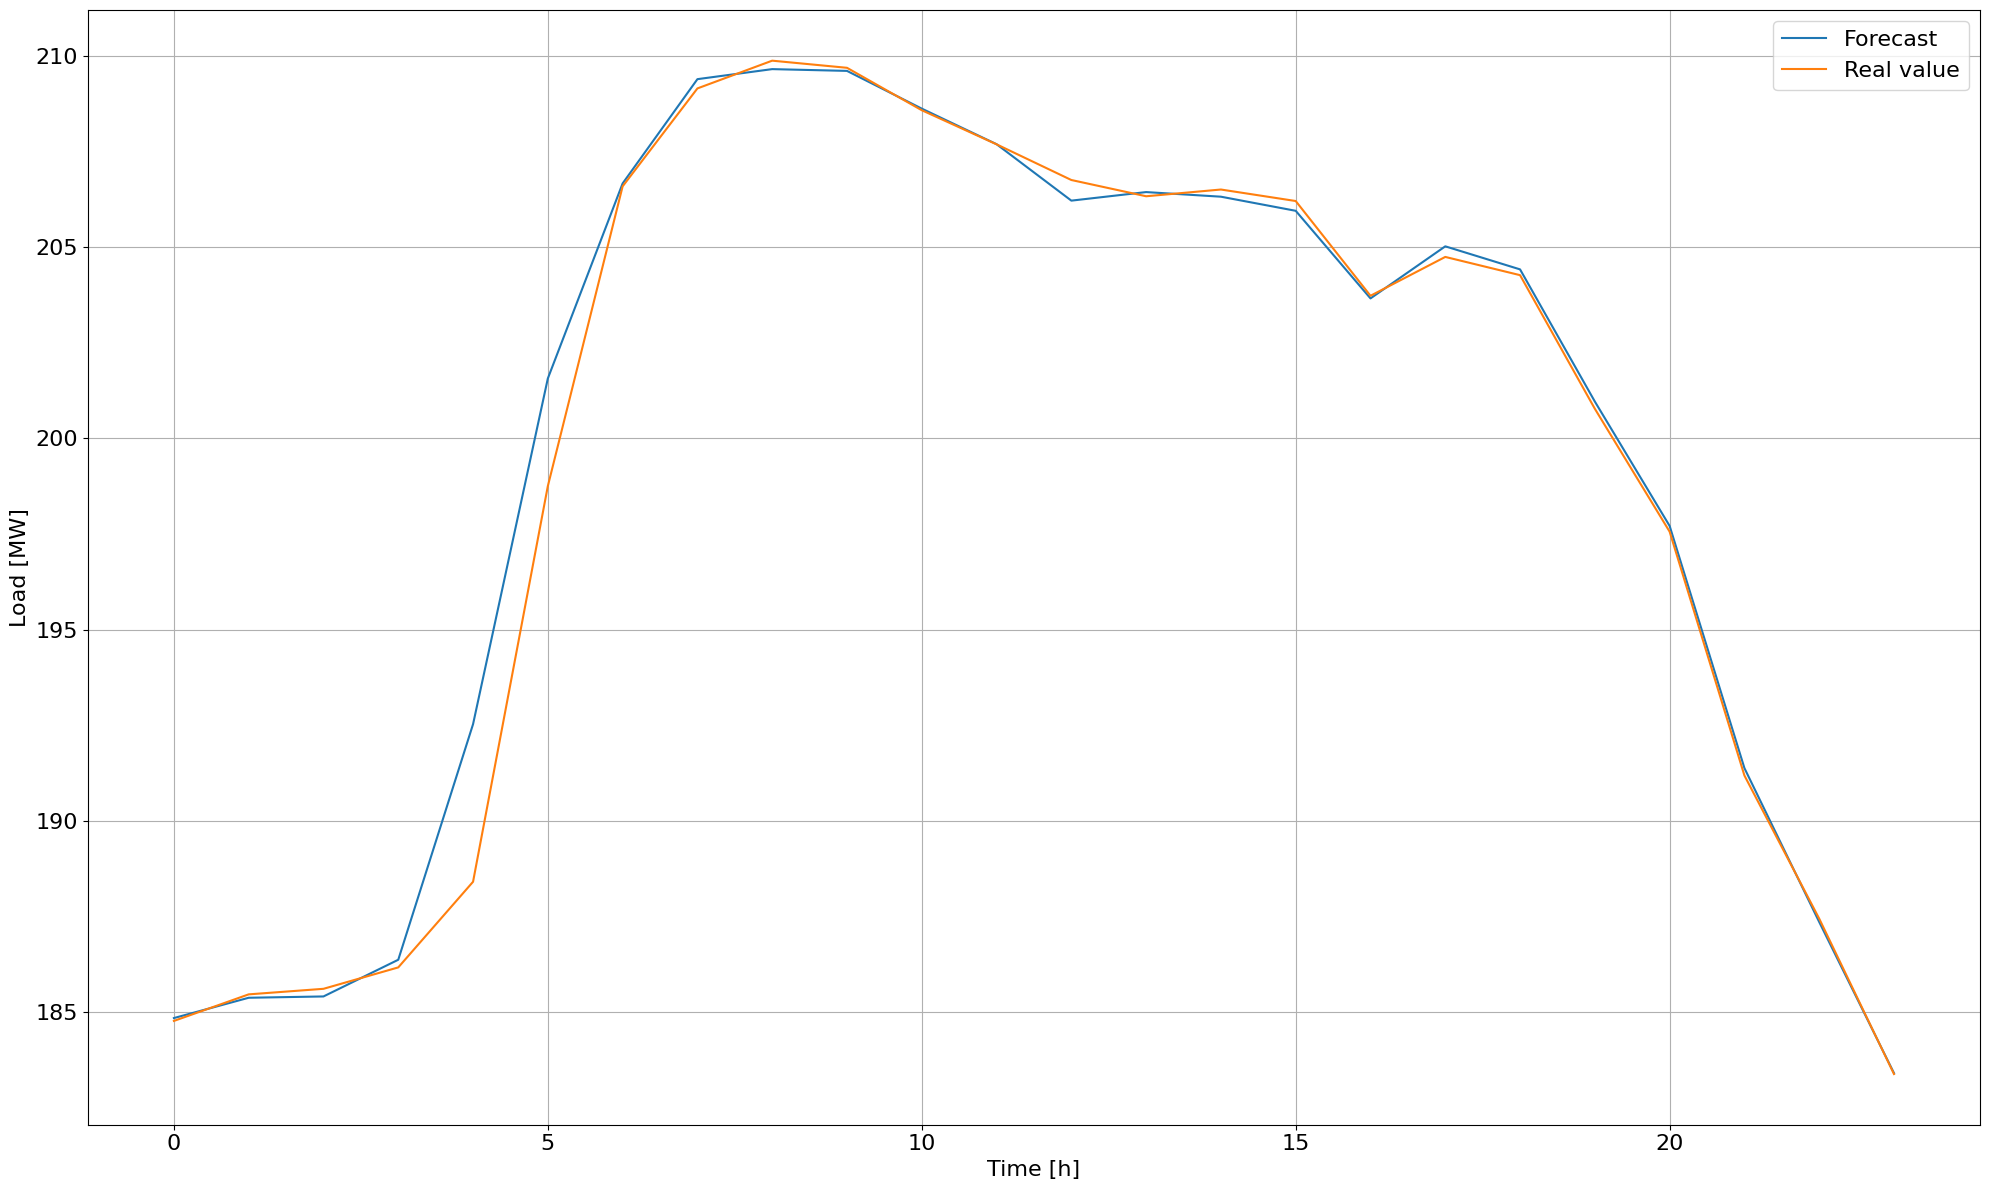

In [41]:
fontsize = 16
plot_df = pd.DataFrame({"Forecast" : test_forecasts[0], "Real value" : test_data.iloc[:24, 0].to_numpy()}, index=range(24))

fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecast"], label="Forecast")
plt.plot(plot_df.index, plot_df["Real value"], label="Real value")

plt.xlabel('Time [h]', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Load [MW]", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()

In [43]:
data = {}
tr_data = {}
ts_data = {}

trained_models = {}
mae = {}

for bus in range(1, 29):
    df = pd.read_csv(f"./data/bus_{bus}_load.csv")
    df.index = pd.to_datetime(df.index, unit='h', origin=pd.Timestamp('2018-01-01'))
    df.index.name = "Time"

    data[bus] = df

    training_data = df[df.index < "2018-10-16"]

    test_data = df[df.index >= "2018-10-16"]
    test_data = df[df.index <= "2018-12-31"]

    tr_data[bus] = training_data
    ts_data[bus] = test_data

    hyperparameters = {
    "in_length" : 7*24, #Lagged values
    "step_size" : 1, 
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : ["Load"]
    }

    horizon = 24

    training_indices = utils.get_indices_entire_sequence(
        data=training_data, 
        window_size=hyperparameters["in_length"] + horizon, 
        step_size=hyperparameters["step_size"]
        )

    x_train, y_train = utils.get_xgboost_x_y(
        indices=training_indices, 
        data=training_data[hyperparameters["selected_features"]].to_numpy(),
        target_sequence_length = horizon,
        input_seq_len=hyperparameters["in_length"]
        )

    test_indices = utils.get_indices_entire_sequence(
        data=test_data, 
        window_size=hyperparameters["in_length"] + horizon, 
        step_size=24
        )

    # Obtain (X,Y) pairs of test data
    x_test, y_test = utils.get_xgboost_x_y(
        indices=test_indices, 
        data=test_data[hyperparameters["selected_features"]].to_numpy(),
        target_sequence_length = horizon,
        input_seq_len = hyperparameters["in_length"]
        )
    

    model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

    trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

    trained_models[bus] = trained_model

    
    test_forecasts = trained_model.predict(x_test)
    test_mae = mean_absolute_error(y_test, test_forecasts)

    mae[bus] = test_mae




    

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Preparing data..
Finished preparin

In [45]:
def predict(bus, x_data):
    model = trained_models[bus]

    return model.predict(x_data)